In [62]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from tqdm import tqdm
from pymle.models import GeometricBM, OrnsteinUhlenbeck
from pymle.core.TransitionDensity import KesslerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE
import aleatory

In [63]:
pd.options.display.max_rows = 500
day=-2
market_data = pd.read_csv(f'/Users/zackienzle/Library/CloudStorage/OneDrive-Personal/DEV/Projects/Quant Preparation/Assigned/IMC/Prosperity25/prices_round_1_day_{day}.csv', sep=';', header=0)
trade_history = pd.read_csv(f"/Users/zackienzle/Library/CloudStorage/OneDrive-Personal/DEV/Projects/Quant Preparation/Assigned/IMC/Prosperity25/trades_round_1_day_{day}.csv", sep=";", header=0)
market_data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
2,-2,0,SQUID_INK,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
3,-2,100,SQUID_INK,1999,5,1998.0,26.0,NaN,NaN,2001,20,NaN,NaN,NaN,NaN,2000.0,0.0
4,-2,100,RAINFOREST_RESIN,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,-2,999800,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,9998,1,10002.0,9.0,10004.0,1.0,9997.0,0.0
29996,-2,999800,KELP,2026,26,NaN,NaN,NaN,NaN,2028,3,2030.0,26.0,NaN,NaN,2027.0,0.0
29997,-2,999900,RAINFOREST_RESIN,9996,2,9995.0,30.0,NaN,NaN,10004,2,10005.0,30.0,NaN,NaN,10000.0,0.0
29998,-2,999900,KELP,2027,4,2026.0,32.0,NaN,NaN,2029,32,NaN,NaN,NaN,NaN,2028.0,0.0


In [64]:
kelp_data = market_data[market_data['product'] == 'KELP'].reset_index(drop=True)
kelp_data['bid_volume_1'].value_counts()

bid_volume_1
1     957
30    724
28    695
27    693
26    688
29    686
23    663
25    660
22    634
24    620
21    479
31    445
2     371
20    266
32    264
3     166
5     150
4     145
6     133
7      88
8      75
33     64
35     62
34     58
9      40
36     38
37     33
19     22
10     18
38     17
18     15
14      6
39      5
17      5
13      4
12      4
11      2
15      2
40      2
16      1
Name: count, dtype: int64

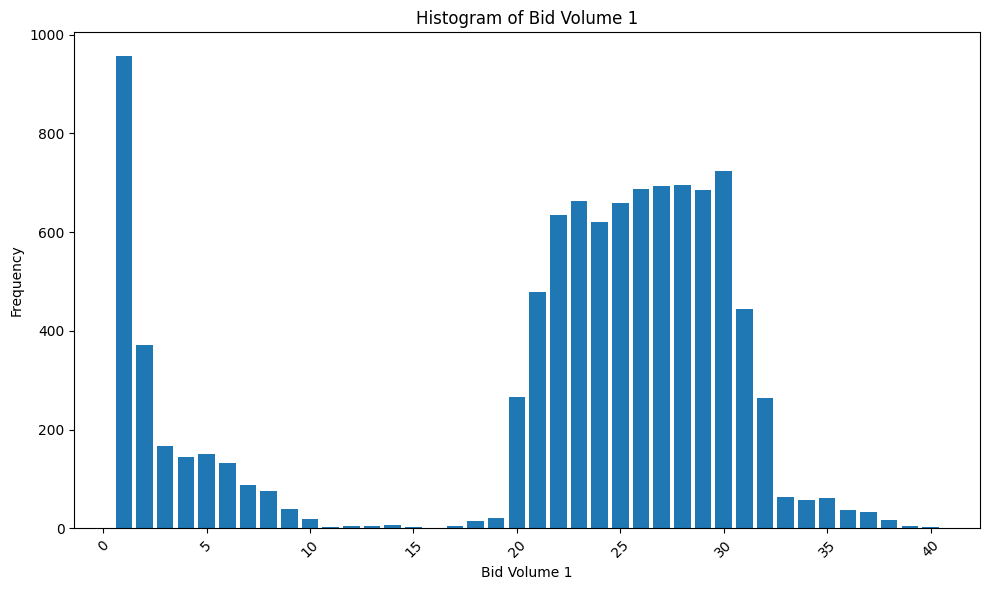

In [65]:
bid_volume_counts = kelp_data['bid_volume_1'].value_counts()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(bid_volume_counts.index, bid_volume_counts.values)
plt.xlabel('Bid Volume 1')
plt.ylabel('Frequency')
plt.title('Histogram of Bid Volume 1')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

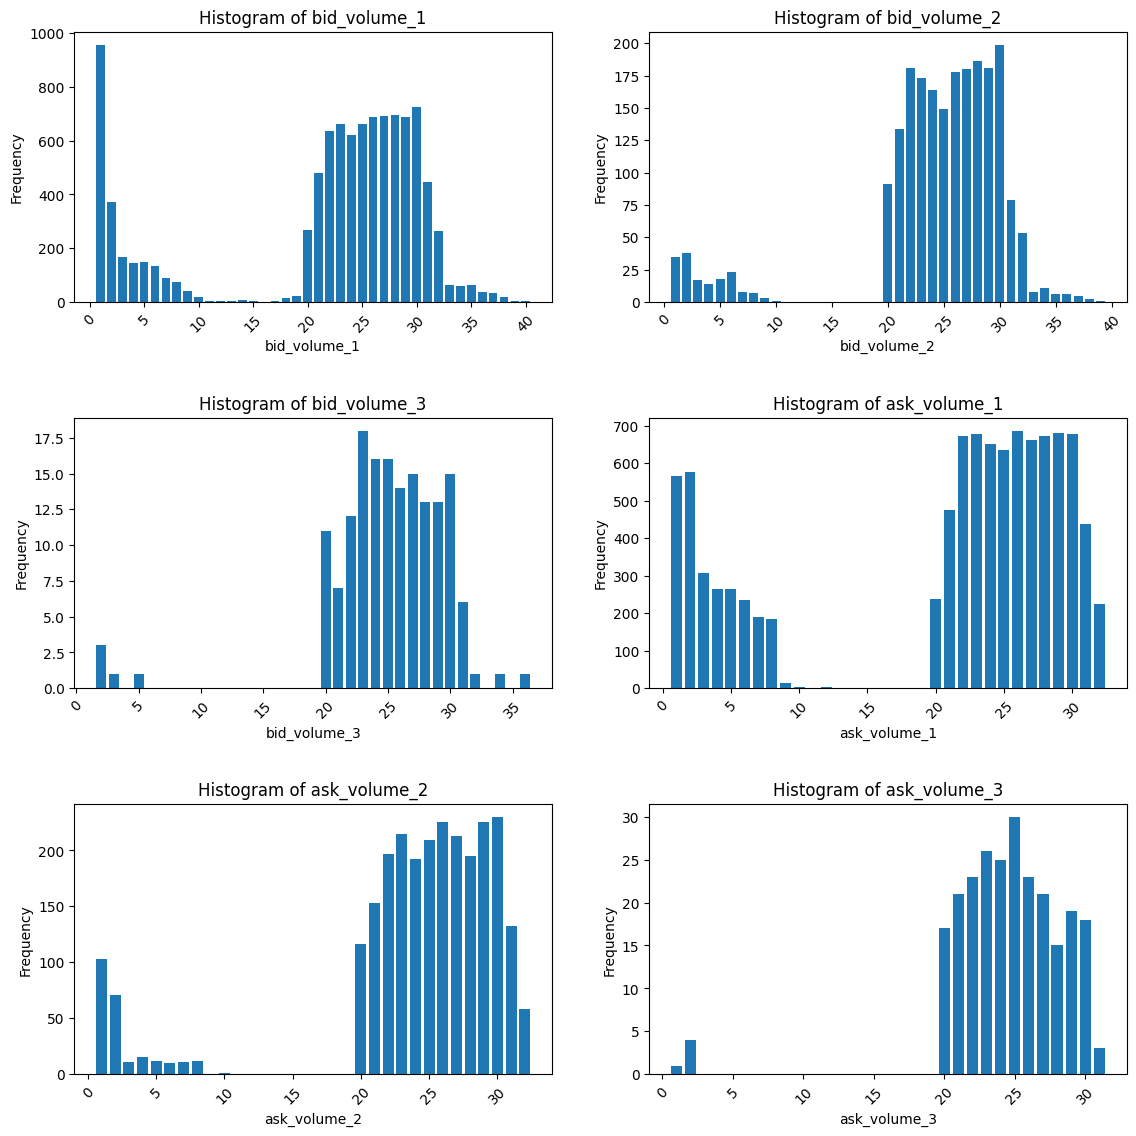

In [66]:
columns_to_plot = ['bid_volume_1', 'bid_volume_2', 'bid_volume_3',
                   'ask_volume_1', 'ask_volume_2', 'ask_volume_3']

num_plots = len(columns_to_plot)
num_rows = (num_plots + 1) // 2
num_cols = 2

plt.figure(figsize=(12, 4 * num_rows))

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    volume_counts = kelp_data[column].value_counts()
    
    plt.bar(volume_counts.index, volume_counts.values)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout(pad=3.0)

plt.show();

In [67]:
def calculate_mm_mid(row):
    # Find the best bid with volume >= 20
    for i in range(1, 4):
        if row[f'bid_volume_{i}'] >= 20:
            best_bid = row[f'bid_price_{i}']
            break
    else:
        best_bid = None

    for i in range(1, 4):
        if row[f'ask_volume_{i}'] >= 20:
            best_ask = row[f'ask_price_{i}']
            break
    else:
        best_ask = None

    # Calculate the mid price if both best bid and ask are found
    if best_bid is not None and best_ask is not None:
        return (best_bid + best_ask) / 2
    else:
        return None

kelp_data['mm_mid'] = kelp_data.apply(calculate_mm_mid, axis=1)
kelp_data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,mm_mid
0,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0,2000.0
1,-2,100,KELP,2000,5,1999.0,6.0,1998.0,20.0,2002,20,NaN,NaN,NaN,NaN,2001.0,0.0,2000.0
2,-2,200,KELP,1999,1,1998.0,30.0,NaN,NaN,2002,31,NaN,NaN,NaN,NaN,2000.5,0.0,2000.0
3,-2,300,KELP,1999,27,NaN,NaN,NaN,NaN,2002,27,NaN,NaN,NaN,NaN,2000.5,0.0,2000.5
4,-2,400,KELP,1999,20,NaN,NaN,NaN,NaN,2002,20,NaN,NaN,NaN,NaN,2000.5,0.0,2000.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-2,999500,KELP,2027,26,NaN,NaN,NaN,NaN,2030,26,NaN,NaN,NaN,NaN,2028.5,0.0,2028.5
9996,-2,999600,KELP,2027,30,NaN,NaN,NaN,NaN,2030,30,NaN,NaN,NaN,NaN,2028.5,0.0,2028.5
9997,-2,999700,KELP,2026,22,NaN,NaN,NaN,NaN,2030,22,NaN,NaN,NaN,NaN,2028.0,0.0,2028.0
9998,-2,999800,KELP,2026,26,NaN,NaN,NaN,NaN,2028,3,2030.0,26.0,NaN,NaN,2027.0,0.0,2028.0


In [68]:
# Create the plot using Plotly Express
fig = px.line(kelp_data, x='timestamp', y='mm_mid', title='MM Mid Price Over Time')

# Customize the layout
fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='MM Mid Price',
)

# Display the plot
fig.show()

In [69]:
kelp_fair_prices = kelp_data[['timestamp', 'mm_mid']]

In [70]:
kelp_fair_prices = kelp_fair_prices.rename(columns={'mm_mid': 'fair'})
kelp_fair_prices

,timestamp,fair
0,0,2000.0
1,100,2000.0
2,200,2000.0
3,300,2000.5
4,400,2000.5
...,...,...
9995,999500,2028.5
9996,999600,2028.5
9997,999700,2028.0
9998,999800,2028.0


In [71]:
iteration_counts = [1,2,5,10,50, 100, 500,]

In [72]:
for iterations in iteration_counts:
    kelp_fair_prices[f"fair_in_{iterations}_its"] = kelp_fair_prices['fair'].shift(-iterations)
    kelp_fair_prices[f"fair_{iterations}_its_ago"] = kelp_fair_prices['fair'].shift(iterations)
kelp_fair_prices

,timestamp,fair,fair_in_1_its,fair_1_its_ago,fair_in_2_its,fair_2_its_ago,fair_in_5_its,fair_5_its_ago,fair_in_10_its,fair_10_its_ago,fair_in_50_its,fair_50_its_ago,fair_in_100_its,fair_100_its_ago,fair_in_500_its,fair_500_its_ago
0,0,2000.0,2000.0,NaN,2000.0,NaN,2000.5,NaN,2000.5,NaN,NaN,NaN,1999.0,NaN,2000.0,NaN
1,100,2000.0,2000.0,2000.0,2000.5,NaN,2000.5,NaN,2000.5,NaN,2000.5,NaN,1999.5,NaN,1999.5,NaN
2,200,2000.0,2000.5,2000.0,2000.5,2000.0,2000.5,NaN,2000.5,NaN,2000.5,NaN,1999.5,NaN,1999.5,NaN
3,300,2000.5,2000.5,2000.0,2000.5,2000.0,2000.5,NaN,2000.5,NaN,2000.5,NaN,1999.5,NaN,1999.5,NaN
4,400,2000.5,2000.5,2000.5,2000.5,2000.0,2000.5,NaN,2000.5,NaN,2000.5,NaN,1999.5,NaN,2000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,999500,2028.5,2028.5,2028.5,2028.0,2028.0,NaN,2028.0,NaN,2027.0,NaN,2027.5,NaN,2024.5,NaN,2030.0
9996,999600,2028.5,2028.0,2028.5,2028.0,2028.5,NaN,2028.0,NaN,2027.5,NaN,2027.5,NaN,2024.5,NaN,2030.0
9997,999700,2028.0,2028.0,2028.5,2027.5,2028.5,NaN,2028.0,NaN,2027.5,NaN,2027.0,NaN,2025.0,NaN,2030.0
9998,999800,2028.0,2027.5,2028.0,NaN,2028.5,NaN,2028.0,NaN,2027.5,NaN,2027.0,NaN,2025.5,NaN,2030.5


In [73]:
for iterations in iteration_counts:
    kelp_fair_prices[f'returns_in_{iterations}_its'] = (kelp_fair_prices[f'fair_in_{iterations}_its'] - kelp_fair_prices['fair'])/kelp_fair_prices['fair']
    kelp_fair_prices[f'returns_from_{iterations}_its_ago'] = (kelp_fair_prices['fair'] - kelp_fair_prices[f'fair_{iterations}_its_ago'])/kelp_fair_prices[f'fair_{iterations}_its_ago']
kelp_fair_prices.columns

Index(['timestamp', 'fair', 'fair_in_1_its', 'fair_1_its_ago', 'fair_in_2_its',
       'fair_2_its_ago', 'fair_in_5_its', 'fair_5_its_ago', 'fair_in_10_its',
       'fair_10_its_ago', 'fair_in_50_its', 'fair_50_its_ago',
       'fair_in_100_its', 'fair_100_its_ago', 'fair_in_500_its',
       'fair_500_its_ago', 'returns_in_1_its', 'returns_from_1_its_ago',
       'returns_in_2_its', 'returns_from_2_its_ago', 'returns_in_5_its',
       'returns_from_5_its_ago', 'returns_in_10_its',
       'returns_from_10_its_ago', 'returns_in_50_its',
       'returns_from_50_its_ago', 'returns_in_100_its',
       'returns_from_100_its_ago', 'returns_in_500_its',
       'returns_from_500_its_ago'],
      dtype='object')

In [74]:
kelp_returns = kelp_fair_prices[['timestamp','fair','returns_in_1_its', 'returns_from_1_its_ago',
       'returns_in_2_its', 'returns_from_2_its_ago', 'returns_in_5_its',
       'returns_from_5_its_ago', 'returns_in_10_its',
       'returns_from_10_its_ago', 'returns_in_50_its',
       'returns_from_50_its_ago', 'returns_in_100_its',
       'returns_from_100_its_ago', 'returns_in_500_its',
       'returns_from_500_its_ago']]

In [75]:
kelp_returns= kelp_returns.dropna()
kelp_returns

,timestamp,fair,returns_in_1_its,returns_from_1_its_ago,returns_in_2_its,returns_from_2_its_ago,returns_in_5_its,returns_from_5_its_ago,returns_in_10_its,returns_from_10_its_ago,returns_in_50_its,returns_from_50_its_ago,returns_in_100_its,returns_from_100_its_ago,returns_in_500_its,returns_from_500_its_ago
500,50000,2000.0,-0.000250,0.000250,-0.000250,0.000000,0.000000,0.000250,0.000000,0.000250,0.001000,0.000250,0.002000,0.000751,0.001250,0.000000
501,50100,1999.5,0.000000,-0.000250,0.000000,0.000000,0.000250,0.000000,0.000250,0.000000,0.001500,0.000000,0.002251,0.000500,0.001500,-0.000250
502,50200,1999.5,0.000000,0.000000,0.000250,-0.000250,0.000250,0.000000,0.000500,0.000000,0.001500,0.000000,0.002251,0.000500,0.001500,-0.000250
503,50300,1999.5,0.000250,0.000000,0.000250,0.000000,0.000250,-0.000250,0.000250,0.000000,0.001500,0.000000,0.002251,0.000500,0.001500,-0.000500
504,50400,2000.0,0.000000,0.000250,0.000000,0.000250,0.000250,0.000250,0.000250,0.000250,0.001250,0.000250,0.001750,0.000751,0.001250,-0.000250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9493,949300,2030.0,0.000000,-0.000246,0.000000,-0.000246,0.000246,-0.000246,0.000246,-0.000492,0.000000,0.000246,0.000000,-0.000738,-0.000985,0.000000
9495,949500,2030.0,0.000000,0.000000,0.000000,0.000000,0.000246,-0.000246,0.000000,-0.000492,0.000246,0.000246,-0.000246,-0.000738,-0.000739,-0.000246
9496,949600,2030.0,0.000000,0.000000,0.000246,0.000000,0.000246,-0.000246,0.000000,-0.000246,0.000246,0.000246,-0.000246,-0.000738,-0.000739,-0.000246
9497,949700,2030.0,0.000246,0.000000,0.000246,0.000000,0.000246,-0.000246,-0.000246,0.000000,0.000246,0.000246,-0.000246,-0.000738,-0.000985,-0.000246


In [76]:
kelp_returns.mean()

timestamp                   4.973517e+05
fair                        2.011549e+03
returns_in_1_its            9.789387e-07
returns_from_1_its_ago      1.591505e-06
returns_in_2_its            2.778277e-06
returns_from_2_its_ago      2.841956e-06
returns_in_5_its            7.687378e-06
returns_from_5_its_ago      7.175265e-06
returns_in_10_its           1.564865e-05
returns_from_10_its_ago     1.519722e-05
returns_in_50_its           8.293293e-05
returns_from_50_its_ago     8.436736e-05
returns_in_100_its          1.528374e-04
returns_from_100_its_ago    1.725859e-04
returns_in_500_its          6.819358e-04
returns_from_500_its_ago    8.981537e-04
dtype: float64

In [77]:
# Perform train-test split
train_data, test_data = train_test_split(kelp_returns, test_size=0.2, random_state=42)

# Iterate over each iteration count
for iterations in tqdm(iteration_counts):
    # Prepare the feature and target columns
    X_train = train_data[f'returns_from_{iterations}_its_ago'].values.reshape(-1, 1)
    y_train = train_data[f'returns_in_{iterations}_its']
    X_test = test_data[f'returns_from_{iterations}_its_ago'].values.reshape(-1, 1)
    y_test = test_data[f'returns_in_{iterations}_its']

    # Create and train the linear regression model
    model = LinearRegression(fit_intercept=False)
    model.fit(X_train, y_train)

    # Make predictions on train and test data
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    # Calculate R-squared and MSE for train and test data
    train_r2 = r2_score(y_train, train_predictions)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_r2 = r2_score(y_test, test_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)

    # Print the results
    print(f"Iteration Count: {iterations}")
    print(f"Learned Equation: returns_in_{iterations}_its = {model.coef_[0]:.4f} * returns_from_{iterations}_its_ago")
    print(f"Train R-squared: {train_r2:.4f}")
    print(f"Train MSE: {train_mse:.4f}")
    print(f"Test R-squared: {test_r2:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    print()

100%|██████████| 7/7 [00:00<00:00, 843.88it/s]

Iteration Count: 1
Learned Equation: returns_in_1_its = -0.2756 * returns_from_1_its_ago
Train R-squared: 0.0762
Train MSE: 0.0000
Test R-squared: 0.0472
Test MSE: 0.0000

Iteration Count: 2
Learned Equation: returns_in_2_its = -0.2286 * returns_from_2_its_ago
Train R-squared: 0.0518
Train MSE: 0.0000
Test R-squared: 0.0564
Test MSE: 0.0000

Iteration Count: 5
Learned Equation: returns_in_5_its = -0.0970 * returns_from_5_its_ago
Train R-squared: 0.0077
Train MSE: 0.0000
Test R-squared: 0.0135
Test MSE: 0.0000

Iteration Count: 10
Learned Equation: returns_in_10_its = 0.0096 * returns_from_10_its_ago
Train R-squared: -0.0044
Train MSE: 0.0000
Test R-squared: -0.0014
Test MSE: 0.0000

Iteration Count: 50
Learned Equation: returns_in_50_its = -0.0570 * returns_from_50_its_ago
Train R-squared: -0.0210
Train MSE: 0.0000
Test R-squared: -0.0250
Test MSE: 0.0000

Iteration Count: 100
Learned Equation: returns_in_100_its = 0.0153 * returns_from_100_its_ago
Train R-squared: -0.0464
Train MSE: 0

Rainforest Resin

In [78]:
resin_data = market_data[market_data['product'] == 'RAINFOREST_RESIN'].reset_index(drop=True)
resin_data['bid_volume_1'].value_counts()

bid_volume_1
1     3127
2     2712
26     263
3      262
4      257
23     250
21     242
30     240
20     234
5      230
29     226
22     226
24     223
25     218
28     211
27     210
6      203
9      168
7      167
8      154
10     150
11      12
12      11
0        2
14       1
17       1
Name: count, dtype: int64

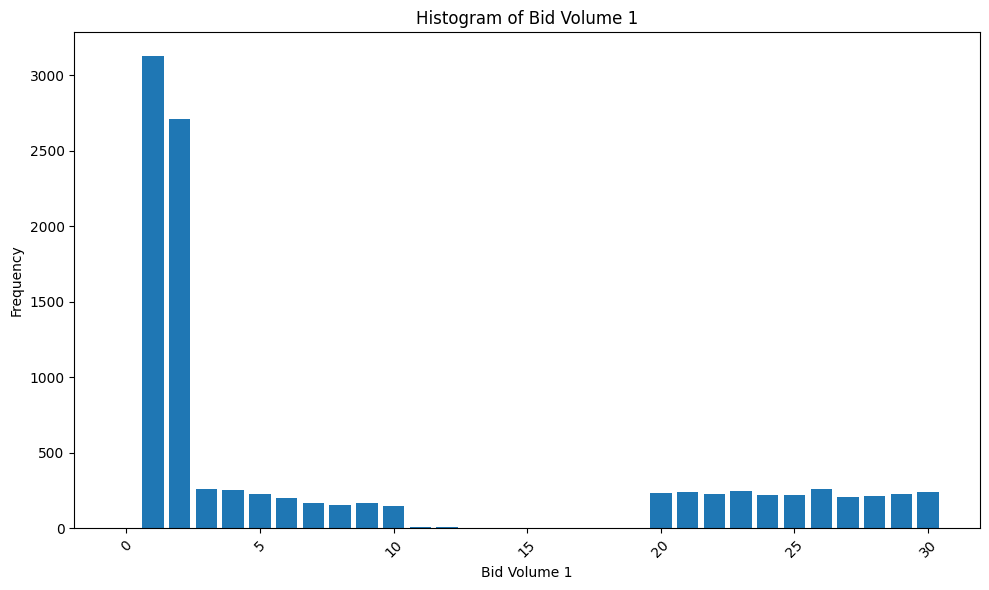

In [79]:
bid_volume_counts = resin_data['bid_volume_1'].value_counts()

# Create a histogram
plt.figure(figsize=(10, 6))
plt.bar(bid_volume_counts.index, bid_volume_counts.values)
plt.xlabel('Bid Volume 1')
plt.ylabel('Frequency')
plt.title('Histogram of Bid Volume 1')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

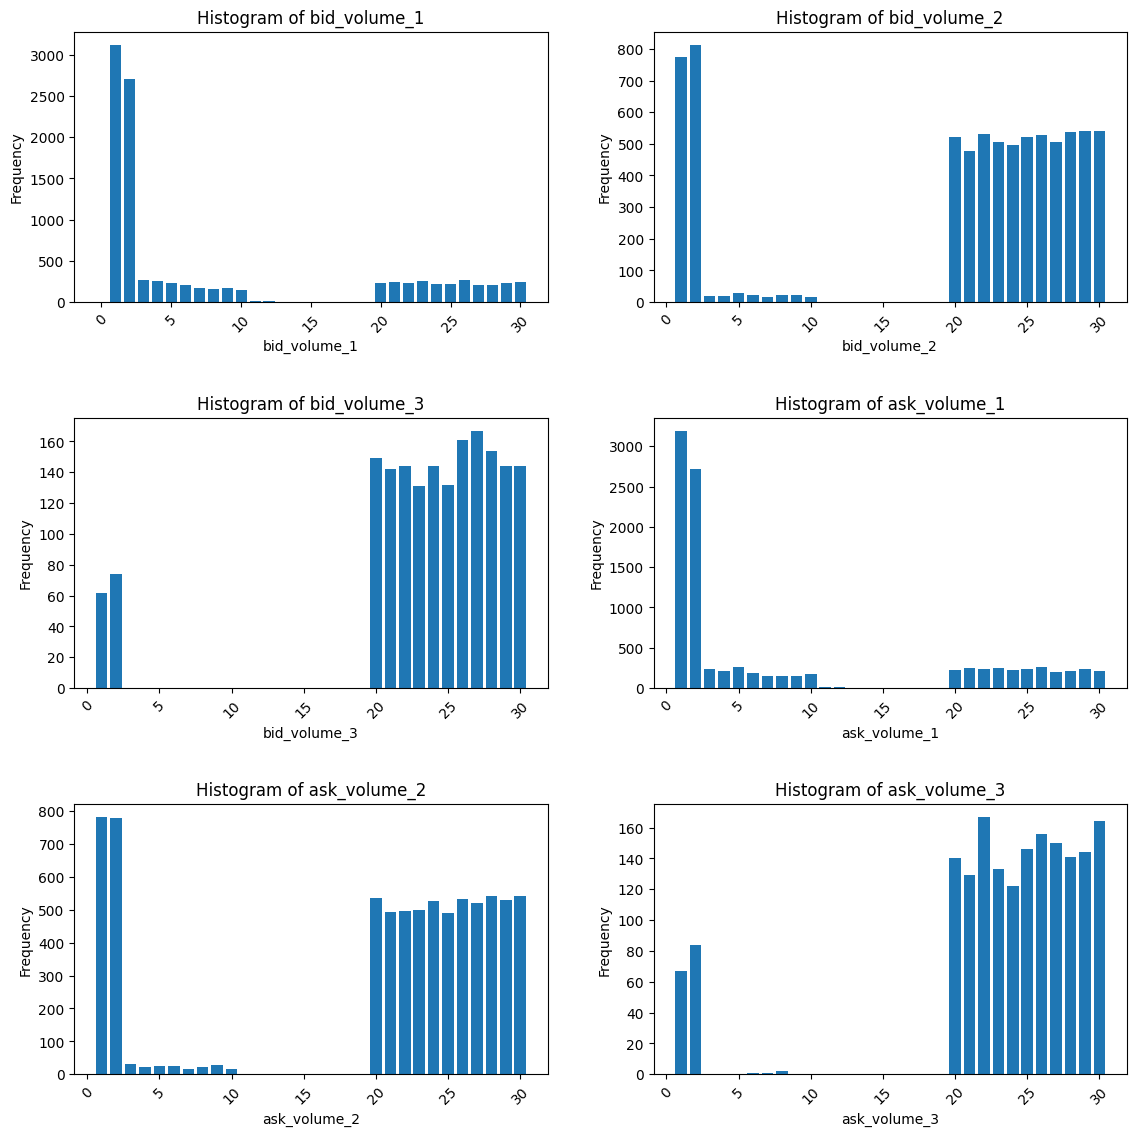

In [80]:
columns_to_plot = ['bid_volume_1', 'bid_volume_2', 'bid_volume_3',
                   'ask_volume_1', 'ask_volume_2', 'ask_volume_3']

num_plots = len(columns_to_plot)
num_rows = (num_plots + 1) // 2
num_cols = 2

plt.figure(figsize=(12, 4 * num_rows))

for i, column in enumerate(columns_to_plot, start=1):
    plt.subplot(num_rows, num_cols, i)
    
    volume_counts = resin_data[column].value_counts()
    
    plt.bar(volume_counts.index, volume_counts.values)
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')
    plt.xticks(rotation=45)
    plt.tight_layout(pad=3.0)

plt.show();

In [82]:
def calculate_mm_mid(row):
    # Find the best bid with volume >= 20
    for i in range(1, 4):
        if row[f'bid_volume_{i}'] >= 20:
            best_bid = row[f'bid_price_{i}']
            break
    else:
        best_bid = None

    for i in range(1, 4):
        if row[f'ask_volume_{i}'] >= 20:
            best_ask = row[f'ask_price_{i}']
            break
    else:
        best_ask = None

    # Calculate the mid price if both best bid and ask are found
    if best_bid is not None and best_ask is not None:
        return (best_bid + best_ask) / 2
    else:
        return None

resin_data['mm_mid'] = resin_data.apply(calculate_mm_mid, axis=1)
resin_data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,mm_mid
0,-2,0,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0,10000.0
1,-2,100,RAINFOREST_RESIN,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0,10000.0
2,-2,200,RAINFOREST_RESIN,9996,1,9995.0,30.0,NaN,NaN,10004,1,10005.0,30.0,NaN,NaN,10000.0,0.0,10000.0
3,-2,300,RAINFOREST_RESIN,9996,1,9995.0,26.0,NaN,NaN,10004,1,10005.0,26.0,NaN,NaN,10000.0,0.0,10000.0
4,-2,400,RAINFOREST_RESIN,9995,20,NaN,NaN,NaN,NaN,9998,3,10002.0,9.0,10005.0,20.0,9996.5,0.0,10000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-2,999500,RAINFOREST_RESIN,9996,2,9995.0,24.0,NaN,NaN,10004,2,10005.0,24.0,NaN,NaN,10000.0,0.0,10000.0
9996,-2,999600,RAINFOREST_RESIN,9998,6,9995.0,30.0,NaN,NaN,10005,30,NaN,NaN,NaN,NaN,10001.5,0.0,10000.0
9997,-2,999700,RAINFOREST_RESIN,9995,22,NaN,NaN,NaN,NaN,10005,22,NaN,NaN,NaN,NaN,10000.0,0.0,10000.0
9998,-2,999800,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,9998,1,10002.0,9.0,10004.0,1.0,9997.0,0.0,NaN


In [83]:
# Create the plot using Plotly Express
fig = px.line(resin_data, x='timestamp', y='mm_mid', title='MM Mid Price Over Time')

# Customize the layout
fig.update_layout(
    xaxis_title='Timestamp',
    yaxis_title='MM Mid Price',
)

# Display the plot
fig.show()

In [84]:
resin_fair_prices = resin_data[['timestamp', 'mm_mid']]
resin_fair_prices

,timestamp,mm_mid
0,0,10000.0
1,100,10000.0
2,200,10000.0
3,300,10000.0
4,400,10000.0
...,...,...
9995,999500,10000.0
9996,999600,10000.0
9997,999700,10000.0
9998,999800,NaN


In [ ]:
# # ===========================
# # Create the Hypothesized model
# # ===========================

# model = GeometricBM()

# # Set bounds for param search, and some psuedo-reasonable initial guess
# param_bounds = [(0.0, 10000), (0.0, 10000)]
# guess = np.array([0.01, 0.1])

# # ===========================
# # Read in the data (interest rate time series)
# # ===========================

# df = resin_data()
# sample = df['mid_price'].values
# dt = 1. / 252  # Daily observations

# # ===========================
# # Fit maximum Likelihood estimators
# # ===========================

# # Fit using Kessler MLE
# kessler_est = AnalyticalMLE(sample, param_bounds, dt, density=KesslerDensity(model)).estimate_params(guess)

# print(f'\nKessler MLE: {kessler_est} \n')

# # Fit using Shoji-Ozaki MLE
# shojioz_est = AnalyticalMLE(sample, param_bounds, dt, density=ShojiOzakiDensity(model)).estimate_params(guess)

# print(f'\nShoji-Ozaki MLE: {shojioz_est}')